In [2]:
#import libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import copy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout, Embedding
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score

In [3]:
#Setting the random seed 
import random
seed = 42
np.random.seed(seed) 
random.seed(seed)

In [4]:
#Importing data
data = pd.read_excel('default of credit card clients.xls',header=1)
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
#replace values 0, 5, 6 with 4 (others category) since they are not mentioned in the data description
data['EDUCATION'].replace([0,5,6],4,inplace=True)
data.EDUCATION.value_counts()

data.drop(columns='ID',inplace=True)
data.rename(columns={"default payment next month": "DEFAULT","PAY_0": "PAY_1"},inplace=True)

In [6]:
#train test split (30%) before scaling and encoding to prevent data leakage 
X_train, X_test, y_train, y_test = train_test_split(data.drop('DEFAULT',axis=1),data['DEFAULT'],test_size=0.3,stratify=data['DEFAULT'])

In [7]:
#one hot encode categorical features and drop the first generated column to prevent multicollinearity
#first ohe train and save columns to apply to test set
X_train_encoded = pd.get_dummies(X_train, columns = ['EDUCATION','MARRIAGE'], drop_first = True)
cols_train = X_train_encoded.columns.tolist()

In [8]:
#ohe X_test and apply the same columns from X_train_encoded
X_test_encoded = pd.get_dummies(X_test,columns = ['EDUCATION','MARRIAGE'], drop_first = True)
X_test_encoded = X_test_encoded.reindex(columns = cols_train).fillna(0)   #if unknown columns assign 0

In [9]:
#numerical columns
numerical_cols = ['LIMIT_BAL', 'AGE','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6',
'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [10]:
#Scaling numerical features
scaler = RobustScaler()

# Fit and transform the scaler on the training data
X_train_scaled_encoded = copy.deepcopy(X_train_encoded)
X_train_scaled_encoded[numerical_cols] = scaler.fit_transform(X_train_encoded[numerical_cols])

# Transform the test data using the fitted scaler
X_test_scaled_encoded = copy.deepcopy(X_test_encoded)
X_test_scaled_encoded[numerical_cols] = scaler.transform(X_test_encoded[numerical_cols])

In [11]:
over = SMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o',over),('u',under)]
pipeline = Pipeline(steps=steps)

In [12]:
X_train_SMOTE = copy.deepcopy(X_train_scaled_encoded)
y_train_SMOTE = copy.deepcopy(y_train)
X_train_SMOTE, y_train_SMOTE =  pipeline.fit_resample(X_train_SMOTE, y_train_SMOTE)

In [13]:
X_train_SMOTE

,LIMIT_BAL,SEX,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,EDUCATION_2,EDUCATION_3,EDUCATION_4,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,0.789474,1,0.153846,0,0,0,0,0,0,2.087982,...,0.633848,0.131848,0.209414,0.362051,1,0,0,1,0,0
1,0.315789,2,0.153846,-1,-1,-1,-1,-1,-1,-0.310379,...,-0.282542,-0.395544,-0.226482,-0.384615,1,0,0,1,0,0
2,0.315789,1,-0.461538,0,0,0,0,0,0,3.117359,...,0.754988,2.768805,1.179413,1.410256,0,0,0,0,1,0
3,-0.684211,2,0.230769,0,-1,0,0,0,0,-0.192367,...,-0.195131,-0.263696,-0.264820,-0.256410,1,0,0,1,0,0
4,0.736842,2,-0.384615,0,0,0,0,0,0,1.999693,...,0.945012,1.160261,1.205672,1.179487,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19621,-0.631579,1,0.708271,0,0,0,0,0,0,-0.144369,...,-0.081657,-0.245543,-0.205891,-0.238786,1,0,0,1,0,0
19622,-0.610531,1,-0.400045,1,-2,-2,-2,-2,-2,-0.349716,...,-0.432660,-0.395544,-0.396114,-0.384615,1,0,0,1,0,0
19623,-0.191171,1,-0.538462,1,2,0,0,0,0,0.570358,...,0.057892,0.127288,0.216707,-0.109346,1,0,0,0,1,0
19624,-0.124371,2,0.014210,-1,2,2,-1,-1,0,-0.339591,...,-0.396786,-0.103777,-0.356455,-0.345890,0,0,0,1,0,0


In [12]:
temp_cols = ['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
static_cols = ['LIMIT_BAL', 'SEX', 'AGE','EDUCATION_2', 'EDUCATION_3',
       'EDUCATION_4', 'MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3']

In [13]:
X_train_temp = X_train_SMOTE[temp_cols]
X_train_static = X_train_SMOTE[static_cols]
X_test_temp = X_test_scaled_encoded[temp_cols]
X_test_static = X_test_scaled_encoded[static_cols]

In [14]:
#3 temporal features in reverse column order (April to September)
PAY = X_train_temp.iloc[:,5::-1]
BILL_AMT = X_train_temp.iloc[:,11:5:-1]
PAY_AMT = X_train_temp.iloc[:,:11:-1]

PAY = PAY.to_numpy()
BILL_AMT = BILL_AMT.to_numpy()
PAY_AMT = PAY_AMT.to_numpy()

#3D array with 21000 customers on y axis, 6 months on x axis, 3 features per month on z axis 
stacked = np.dstack((PAY,BILL_AMT,PAY_AMT))

y_train_array = y_train_SMOTE.to_numpy()

In [15]:
#3 temporal features in reverse column order (April to September)
PAY_test = X_test_temp.iloc[:,5::-1]
BILL_AMT_test = X_test_temp.iloc[:,11:5:-1]
PAY_AMT_test = X_test_temp.iloc[:,:11:-1]

PAY_test = PAY_test.to_numpy()
BILL_AMT_test = BILL_AMT_test.to_numpy()
PAY_AMT_test = PAY_AMT_test.to_numpy()

#3D array with 21000 customers on y axis, 6 months on x axis, 3 features per month on z axis 
stacked_test = np.dstack((PAY_test,BILL_AMT_test,PAY_AMT_test))

y_test_array = y_test.to_numpy()

In [16]:
PAY = PAY.reshape(19626, 6,1)

In [17]:
BILL_AMT = BILL_AMT.reshape(19626, 6,1)
PAY_AMT = PAY_AMT.reshape(19626, 6,1)

In [18]:
PAY_AMT.shape

(19626, 6, 1)

In [19]:
##PAY ONLY

num_time_steps, num_features = PAY.shape[1], PAY.shape[2]

# Define the cnn model_PAY
model_PAY = Sequential()
model_PAY.add(Conv1D(filters=16, kernel_size=3, activation='relu',padding='same', input_shape=(num_time_steps, num_features)))
model_PAY.add(MaxPooling1D(pool_size=3))
model_PAY.add(Conv1D(filters=32, padding='same', kernel_size=2, activation='relu'))
model_PAY.add(MaxPooling1D(pool_size=2))
model_PAY.add(Flatten())
model_PAY.add(Dropout(0.2))
model_PAY.add(Dense(1, activation='sigmoid'))

# Compile the model_PAY
model_PAY.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model_PAY
epochs = 40
batch_size = 512

model_PAY.fit(PAY, y_train_array, epochs=epochs, batch_size=batch_size, validation_data=(PAY_test, y_test_array),shuffle=False)

# Make predictions on the test set
y_pred_probs_PAY = model_PAY.predict(PAY_test)
y_pred_PAY = (y_pred_probs_PAY>=0.5).astype(int)

# Evaluate the model_PAY
loss_PAY, accuracy_PAY = model_PAY.evaluate(PAY_test, y_test_array)
print(f'Test Loss: {loss_PAY:.4f}')
print(f'Test Accuracy: {accuracy_PAY:.4f}')


Epoch 1/40
39/39 [==============================] - 1s 15ms/step - loss: 0.8453 - accuracy: 0.6071 - val_loss: 0.6370 - val_accuracy: 0.7788
Epoch 2/40
39/39 [==============================] - 0s 5ms/step - loss: 0.7103 - accuracy: 0.6664 - val_loss: 0.6135 - val_accuracy: 0.7788
Epoch 3/40
39/39 [==============================] - 0s 4ms/step - loss: 0.6820 - accuracy: 0.6670 - val_loss: 0.5988 - val_accuracy: 0.7788
Epoch 4/40
39/39 [==============================] - 0s 4ms/step - loss: 0.6615 - accuracy: 0.6731 - val_loss: 0.5872 - val_accuracy: 0.7802
Epoch 5/40
39/39 [==============================] - 0s 4ms/step - loss: 0.6455 - accuracy: 0.6997 - val_loss: 0.5789 - val_accuracy: 0.8010
Epoch 6/40
39/39 [==============================] - 0s 4ms/step - loss: 0.6332 - accuracy: 0.7252 - val_loss: 0.5713 - val_accuracy: 0.8003
Epoch 7/40
39/39 [==============================] - 0s 4ms/step - loss: 0.6257 - accuracy: 0.7368 - val_loss: 0.5653 - val_accuracy: 0.7943
Epoch 8/40
39/39 [=

Accuracy: 0.8011111111111111
Precision: 0.5593620791494389
Recall: 0.47564038171772977
F1 score: 0.5141150922909881


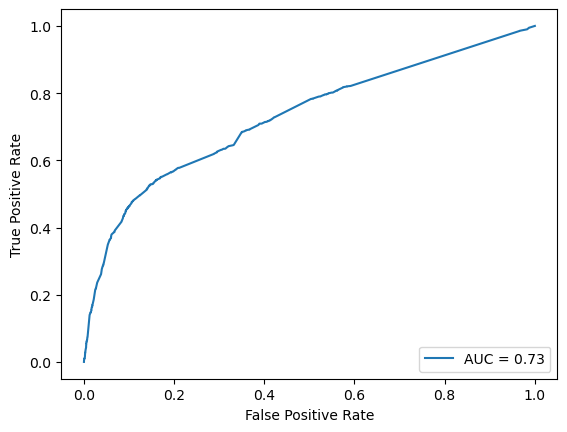

In [20]:
print('Accuracy:', accuracy_score(y_test_array,y_pred_PAY))
print('Precision:', precision_score(y_test_array,y_pred_PAY))
print('Recall:', recall_score(y_test_array,y_pred_PAY))
print('F1 score:', f1_score(y_test_array,y_pred_PAY))


# Calculate the false positive rate, true positive rate, and thresholds for the ROC curve
fpr_PAY, tpr_PAY, thresholds_PAY = roc_curve(y_test_array, y_pred_probs_PAY)

# Calculate the AUC score
auc_score_PAY = roc_auc_score(y_test_array, y_pred_probs_PAY)

# Plot the ROC curve
roc_display_PAY = RocCurveDisplay(fpr=fpr_PAY, tpr=tpr_PAY, roc_auc=auc_score_PAY)
roc_display_PAY.plot()
plt.show()

In [56]:
##BILL_AMT ONLY

num_time_steps, num_features = BILL_AMT.shape[1], BILL_AMT.shape[2]

# Define the LSTM model_BILL_AMT
model_BILL_AMT = Sequential()
model_BILL_AMT.add(Conv1D(filters=32, kernel_size=2, activation='relu',padding='same', input_shape=(num_time_steps, num_features)))
model_BILL_AMT.add(MaxPooling1D(pool_size=3))
#model_BILL_AMT.add(Conv1D(filters=32, padding='same', kernel_size=2, activation='relu'))
#model_BILL_AMT.add(MaxPooling1D(pool_size=2))
model_BILL_AMT.add(Flatten())
model_BILL_AMT.add(Dropout(0.2))
model_BILL_AMT.add(Dense(1, activation='sigmoid'))

# Compile the model_BILL_AMT
model_BILL_AMT.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model_BILL_AMT
epochs = 20
batch_size = 512

model_BILL_AMT.fit(BILL_AMT, y_train_array, epochs=epochs, batch_size=batch_size, validation_data=(BILL_AMT_test, y_test_array),shuffle=False)

# Make predictions on the test set
y_pred_probs_BILL_AMT = model_BILL_AMT.predict(BILL_AMT_test)
y_pred_BILL_AMT = (y_pred_probs_BILL_AMT>=0.5).astype(int)

# Evaluate the model_BILL_AMT
loss_BILL_AMT, accuracy_BILL_AMT = model_BILL_AMT.evaluate(BILL_AMT_test, y_test_array)
print(f'Test Loss: {loss_BILL_AMT:.4f}')
print(f'Test Accuracy: {accuracy_BILL_AMT:.4f}')


Epoch 1/20
39/39 [==============================] - 1s 10ms/step - loss: 0.7442 - accuracy: 0.4833 - val_loss: 0.6310 - val_accuracy: 0.7750
Epoch 2/20
39/39 [==============================] - 0s 4ms/step - loss: 0.6828 - accuracy: 0.6346 - val_loss: 0.6054 - val_accuracy: 0.7788
Epoch 3/20
39/39 [==============================] - 0s 4ms/step - loss: 0.6679 - accuracy: 0.6595 - val_loss: 0.5953 - val_accuracy: 0.7788
Epoch 4/20
39/39 [==============================] - 0s 4ms/step - loss: 0.6621 - accuracy: 0.6631 - val_loss: 0.5894 - val_accuracy: 0.7788
Epoch 5/20
39/39 [==============================] - 0s 4ms/step - loss: 0.6587 - accuracy: 0.6647 - val_loss: 0.5855 - val_accuracy: 0.7788
Epoch 6/20
39/39 [==============================] - 0s 4ms/step - loss: 0.6578 - accuracy: 0.6647 - val_loss: 0.5826 - val_accuracy: 0.7788
Epoch 7/20
39/39 [==============================] - 0s 4ms/step - loss: 0.6561 - accuracy: 0.6649 - val_loss: 0.5805 - val_accuracy: 0.7788
Epoch 8/20
39/39 [=

Accuracy: 0.7781111111111111
Precision: 0.2
Recall: 0.0010045203415369162
F1 score: 0.0019990004997501253


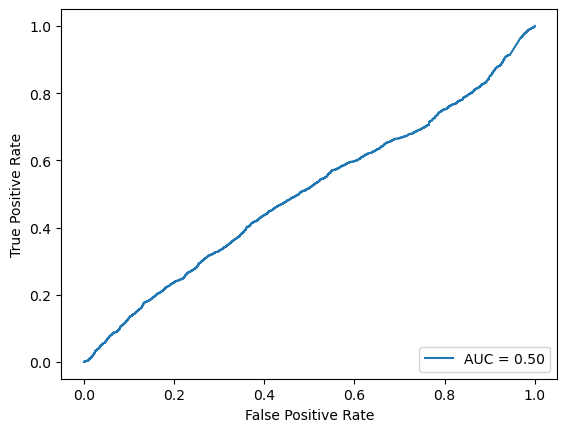

In [52]:
print('Accuracy:', accuracy_score(y_test_array,y_pred_BILL_AMT))
print('Precision:', precision_score(y_test_array,y_pred_BILL_AMT))
print('Recall:', recall_score(y_test_array,y_pred_BILL_AMT))
print('F1 score:', f1_score(y_test_array,y_pred_BILL_AMT))


# Calculate the false positive rate, true positive rate, and thresholds for the ROC curve
fpr_BILL_AMT, tpr_BILL_AMT, thresholds_BILL_AMT = roc_curve(y_test_array, y_pred_probs_BILL_AMT)

# Calculate the AUC score
auc_score_BILL_AMT = roc_auc_score(y_test_array, y_pred_probs_BILL_AMT)

# Plot the ROC curve
roc_display_BILL_AMT = RocCurveDisplay(fpr=fpr_BILL_AMT, tpr=tpr_BILL_AMT, roc_auc=auc_score_BILL_AMT)
roc_display_BILL_AMT.plot()
plt.show()